### Overview:

In this notebook the insights gained from exploratory analysis are used to help answer the question around proper stocking requirements for Divvy stations. The goal was to create a model to predict the ratio of trips in / trips out of any given station by day of the week and month of the year. This would allow Divvy to compare this predicted ratio with the current stocking status of their stations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import datetime as dt

In [2]:
df = pd.read_csv('Divvy_data_2017T2.csv')

In [3]:
df.rename(columns={'start_station_trip_count': 'start_trips_whole_year'}, inplace=True)

In [4]:
df.start_time = pd.to_datetime(df.start_time, format='%Y-%m-%d  %H:%M:%S')
df = df.set_index('start_time')
df['month_of_year'] = df.index.month

### First we need to define our target and predictor variables

In [5]:
#find the number of trips leaving each station by day of the week and month of the year
stations_out = df.groupby(['start_station_id', 'day_of_week', 'month_of_year']).count()

#Not all stations had trips arrive at them every single day of the year. These are not currently shown as empty values, data does
#not appear for those days at all. Unstack the month and day of week, to view information for all days, and fill NaN's with 0's.
out = stations_out.unstack(['month_of_year', 'day_of_week'])
out = out.fillna(0)

In [6]:
out.head()

trip_id                                              ...   \
month_of_year         1    2    3    4    5    6    7    8    9    10 ...    
day_of_week            0    0    0    0    0    0    0    0    0    0 ...    
start_station_id                                                      ...    
2                     12   75   51  128  273  322  536  270  330  145 ...    
3                     38  171  107  228  556  477  912  682  614  394 ...    
4                     15  101   28  182  469  399  744  377  431  251 ...    
5                     24   51   35   60  124  147  231  138   95  113 ...    
6                     21   99   41   54  443  398  655  420  417  316 ...    

                 week_of_year                                                 
month_of_year              3    4    5    6     7    8     9    10   11   12  
day_of_week                 6    6    6    6     6    6     6    6    6    6  
start_station_id                                                              
2                          57  293  286  463   749  357   623  162   20   11  
3                         186  585  760  876  1248  796  1020  631  188  113  
4                          74  505  595  867  1052  595   635  369   76   56  
5                          16   63   89  156   197   99    94   89   17   12  
6                         119  404  557  834  1038  759   745  442   66   69  

[5 rows x 2184 columns]

In [7]:
#restack the day and month so we can see the number of trips broken down by these variables with the 0s filled in 
a = out.stack(['day_of_week', 'month_of_year'])

In [8]:
#find the number of trips arriving at each station by day of the week and month of the year
stations_in = df.groupby(['end_station_id', 'day_of_week', 'month_of_year']).count()

#Not all stations had trips leave from them every single day of the year. These are not currently shown as empty values, data does
#not appear for those days at all. Unstack the month and day of week, to view information for all days, and fill NaN's with 0's.
ins = stations_in.unstack(['month_of_year', 'day_of_week'])
ins = ins.fillna(0)

In [9]:
#restack the day and month so we can see the number of trips broken down by these variables with the 0s filled in 
b = ins.stack(['day_of_week', 'month_of_year'])

In [10]:
#create a function to find the trips coming in to trips going out ratio for each station
def io_ratio():
    station_ios = []
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
        if int(a.trip_id.iloc[row]) == 0 & int(b.trip_id.iloc[row]) == 0:
            station_ios.append(1)
        elif b.trip_id.iloc[row] == 0:
            station_ios.append(1/a.trip_id.iloc[row])
        elif a.trip_id.iloc[row] == 0:
            station_ios.append(b.trip_id.iloc[row])
        else:
            io = float(b.trip_id.iloc[row]) / a.trip_id.iloc[row]
            station_ios.append(io)
    
    return station_ios


In [11]:
ratio = io_ratio()

In [12]:
#create a function to find the number of trips coming in and coming out of each station by day of the week and month.
def rides():
    rides_in = []
    rides_out =[]
    
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
            rides_in.append(b.trip_id.iloc[row])
            rides_out.append(a.trip_id.iloc[row])
    
    return rides_in, rides_out

In [13]:
i, o = rides()

In [14]:
avg_duration = df.groupby(['start_station_id', 'day_of_week', 'month_of_year']).mean()


In [15]:
dur = avg_duration.unstack(['month_of_year', 'day_of_week'])
dur = dur.fillna(0)
ad = dur.stack(['day_of_week', 'month_of_year'])

In [16]:
#create a function to find the number average duration starting from each station by day of the week and month.
def average_duration():
    avgdur = []
    
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
            avgdur.append(ad.trip_duration.iloc[row])
    
    return avgdur

avgdur = average_duration()

In [17]:
c = a.reset_index()
c['ratio'] = ratio
c['rides_in'] = i
c['rides_out'] = o
c['average_duration'] = avgdur


In [18]:
#add some additional features
add_features = df.groupby(['start_station_id', 'start_capacity', 'group', 'start_latitude', 'start_longitude' ]).count()
add_features = add_features.reset_index()
add_features = add_features[['start_station_id', 'start_capacity', 'group', 'start_latitude', 'start_longitude']]

In [19]:
af = c.merge(add_features, on='start_station_id')
c['capacity'] = af.start_capacity_y
c['group'] = af.group_y
c['latitude'] = af.start_latitude_y
c['longitude'] = af.start_longitude_y

In [20]:
c['start_station_id'] = c['start_station_id'].astype(float)
c['day_of_week'] = c['day_of_week'].astype(float)
c['month_of_year'] = c['month_of_year'].astype(float)
c['rides_in'] = c['rides_in'].astype(float)
c['rides_out'] = c['rides_out'].astype(float)
c['capacity'] = c['capacity'].astype(float)
c['group'] = c['group'].astype(float)

In [21]:
data = c[['start_station_id','day_of_week','month_of_year', 'capacity', 'group','latitude', 'longitude', 'average_duration', \
              'rides_in', 'rides_out', 'ratio',]]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49140 entries, 0 to 49139
Data columns (total 11 columns):
start_station_id    49140 non-null float64
day_of_week         49140 non-null float64
month_of_year       49140 non-null float64
capacity            49140 non-null float64
group               49140 non-null float64
latitude            49140 non-null float64
longitude           49140 non-null float64
average_duration    49140 non-null float64
rides_in            49140 non-null float64
rides_out           49140 non-null float64
ratio               49140 non-null float64
dtypes: float64(11)
memory usage: 4.5 MB


In [23]:
#target variable
y = data['ratio'].values

In [24]:
#predictor variables
X = data[['start_station_id', 'day_of_week', 'month_of_year', 'average_duration', 'capacity', 'group', \
         'latitude', 'longitude']]

### Feature Selection

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

lasso = Lasso()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)

lasso_coef = lasso.fit(X_train,y_train).coef_

lasso_coef

array([ 7.3062231e-05, -0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -0.0000000e+00])

In [26]:
#station_id was the only coefficent that was not taken down to 0 by lasso. We'll use this along with 
#day of the week and month of the year to build our model.

X =data[['start_station_id', 'day_of_week', 'month_of_year']]

In [27]:
#prep categorical variables to utilize the get_dummies function
X.start_station_id = X.start_station_id.astype('category')
X.month_of_year = X.month_of_year.astype('category')
X.day_of_week = X.day_of_week.astype('category')

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\pandas\core\generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [28]:
X = pd.get_dummies(X)

### Now that we have our predictor and target variables, we can split the data into training and tests sets, and train a model. 

In [29]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [30]:
steps=[('scaler', StandardScaler()), ('reg', LinearRegression())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.060308809223191935


In [31]:
steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=.5, normalize=True))]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha': [.1,.5,1,5,10]}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'ridge__alpha': 0.1}


In [32]:
steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=.1, normalize=True))]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.06402091004585908


### What if we separated out the target variable into classes that can be used for different stocking recommendations, and used our data for classification?

These stocking classes will be based on the trips in to trips out ratio, and will be separated in a way that a different recommendation can be made about stocking requirements for each class.

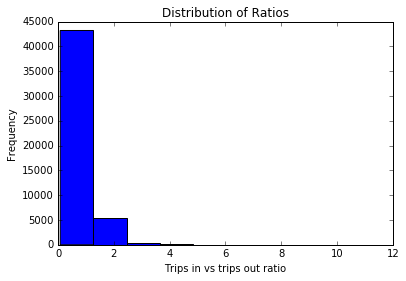

In [33]:
#view the distribution for the ratios - most seem to fall between 0 and 2
plt.hist(data.ratio)
plt.xlabel('Trips in vs trips out ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Ratios')
plt.show()

In [34]:
#separate the stock classes - different ratios would require different degrees of stocking needs

stockclass= []

def separate_stockclass():
    for i in range(len(c.ratio)):
        if c.ratio[i] < .75:
            stockclass.append('0 to .75')
        #elif c.ratio[i] < .8:
        #    stockclass.append('.6 to .9')
        elif c.ratio[i] < 1.4:
            stockclass.append('.75 to 1.4')
        elif c.ratio[i] < 2.5:
            stockclass.append('1.2 to 2')
        elif c.ratio[i] >= 2.5:
            stockclass.append('2.5+')
        else:
            return 'Error'

In [35]:
separate_stockclass()

In [36]:
#new predictor and target variables for classification
data['class'] = stockclass
y1 = data['class']
X1 = data[['start_station_id', 'day_of_week', 'month_of_year']]

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## KNN

In [37]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'knn__n_neighbors': 23}


In [38]:
clf = KNeighborsClassifier(n_neighbors= 24)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.8259055759055759
Test score:  0.8215303215303216
             precision    recall  f1-score   support

 .75 to 1.4       0.82      1.00      0.90      8074
   0 to .75       0.30      0.01      0.03       973
   1.2 to 2       0.67      0.02      0.03       660
       2.5+       0.00      0.00      0.00       121

avg / total       0.75      0.82      0.75      9828



C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 6}
0.7559523809523809


C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [40]:
clf = RandomForestClassifier(n_estimators=19)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state=18)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9870522995522996
Test score:  0.7380952380952381
             precision    recall  f1-score   support

 .75 to 1.4       0.85      0.87      0.86      8136
   0 to .75       0.14      0.13      0.13       934
   1.2 to 2       0.11      0.09      0.10       651
       2.5+       0.01      0.01      0.01       107

avg / total       0.72      0.74      0.73      9828



## Multinomial NB

In [41]:
from sklearn.naive_bayes import MultinomialNB

steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 3}
0.8262362637362637


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size=.2, random_state=15, stratify=y1)

clf = MultinomialNB(alpha=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.8266178266178266
Test score:  0.8269230769230769
             precision    recall  f1-score   support

 .75 to 1.4       0.83      1.00      0.91      8086
   0 to .75       0.60      0.07      0.13       965
   1.2 to 2       0.65      0.02      0.04       661
       2.5+       0.00      0.00      0.00       116

avg / total       0.79      0.83      0.76      9828

